In [ ]:
!pip3 install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, OPTICS

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
import umap

sns.set_style('darkgrid')

In [ ]:
data = pd.read_csv('/content/wheat.csv')

data.head()

,area,perimeter,compactness,length,width,asymmetry coefficient,groove length,category
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1.0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1.0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1.0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1.0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0


В приведенном датасете представлена информация о зернах пшеницы трех различных сортов. Описания колонок:


1. ```area``` - площадь зерна
2. ```perimeter``` - периметр зерна
3. ```compactness``` - плотность зерна
4. ```length``` - длина зерна
5. ```width``` - ширина зерна
6. ```asymmetry coefficient``` - некий показатель асимметричности в форме зерна
7. ```groove length``` - длина бороздки в зерне
8. ```category``` - номер сорта пшеницы

Как нетрудно заметить, исходный датасет является размеченным. Поэтому мы можем попробовать оценить результат работы выбранного алгоритма кластеризации, используя какую-либо стандартную метрики для задачи множественной классификации

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   210 non-null    float64
 1   perimeter              210 non-null    float64
 2   compactness            210 non-null    float64
 3   length                 210 non-null    float64
 4   width                  210 non-null    float64
 5   asymmetry coefficient  210 non-null    float64
 6   groove length          210 non-null    float64
 7   category               210 non-null    float64
dtypes: float64(8)
memory usage: 13.2 KB


Пропущенных значений в колонках нет

In [ ]:
data.category.value_counts()

category
1.0    70
2.0    70
3.0    70
Name: count, dtype: int64

Классы являются сбалансированными, а значит в качестве метрики оценки можно будет использовать простой accuracy

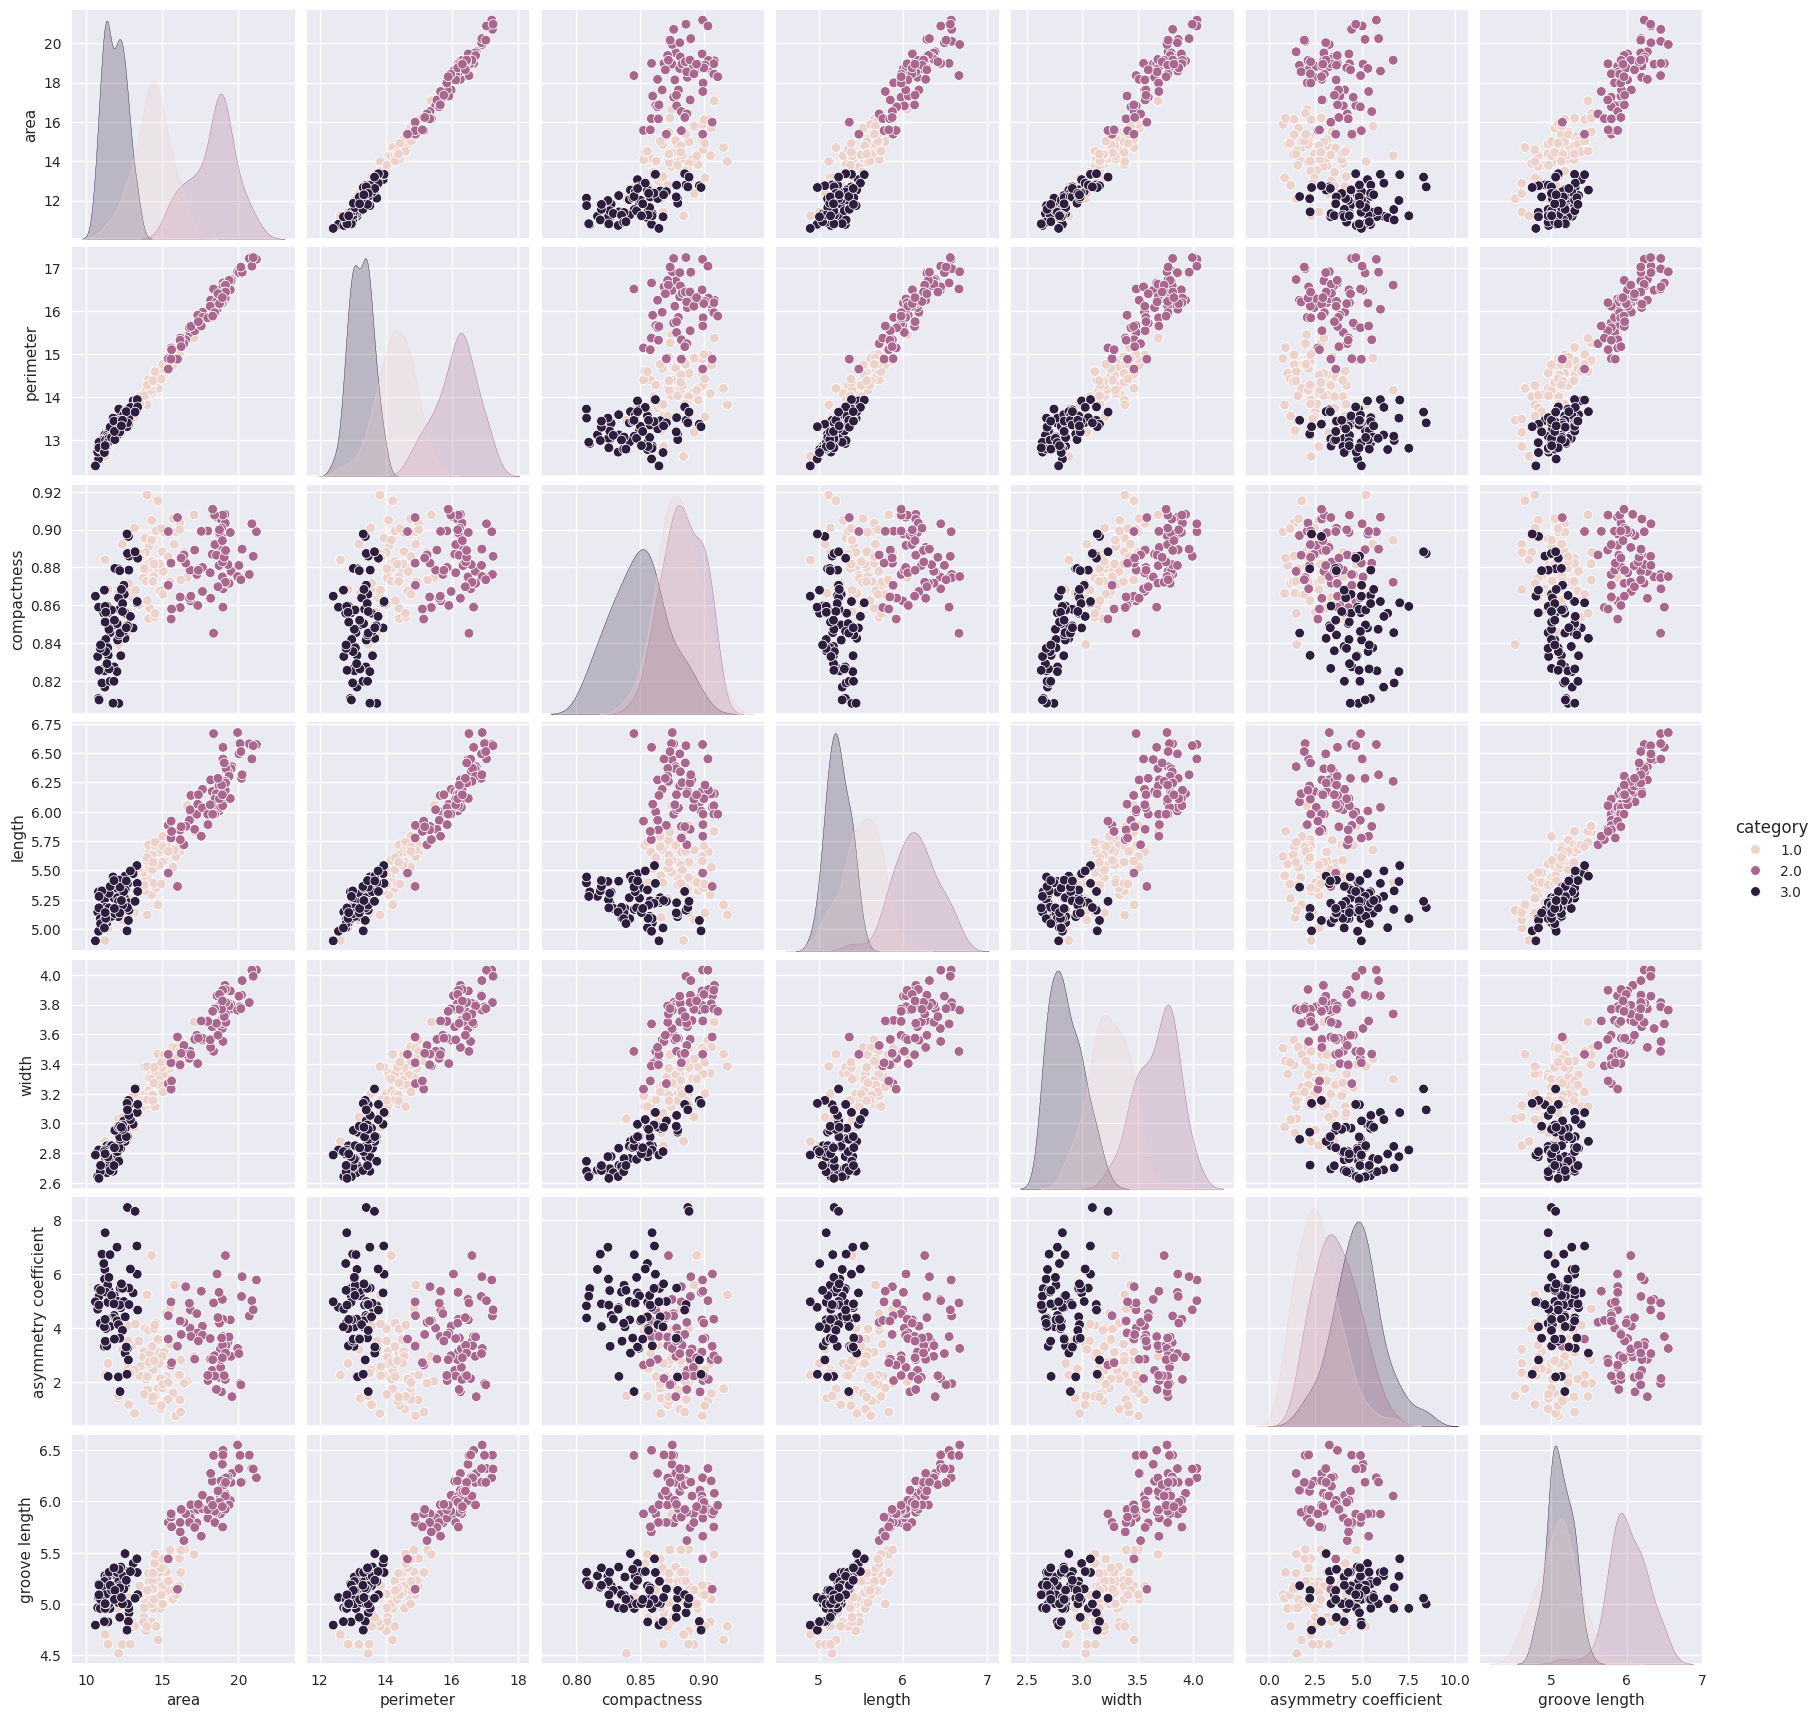

In [ ]:
sns.pairplot(data=data, hue='category')

plt.show()

По построенным парным графиками видно, что во многих случаях исходные классы вполне неплохо разделяются попарно изначальным признакам; следовательно, можно предположить, что понижение размерности с 7 до 2 вполне способно сохранить адекватное разделение классов

In [ ]:
# отскалируем признаки перед началом работы и выкинем разметку классов
SS=StandardScaler()
X=pd.DataFrame(SS.fit_transform(data), columns=data.columns).drop(columns=['category'])

# Кластеризация

Так как мы изнчально знаем, что кластеров должно получится ровно 3, то вполне разумным было бы применить метод K-средних

In [ ]:
# Зададим некоторые начальные параметры
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'tol': 0.0001,
    'random_state': 42,
    'algorithm': 'lloyd'
}

Сперва убедимся в том, что алгоритм правильно идентифицирует оптимальное число кластеров. Для этого построим график зависимости суммы квадратов внутрикластерных расстояний от количества кластеров

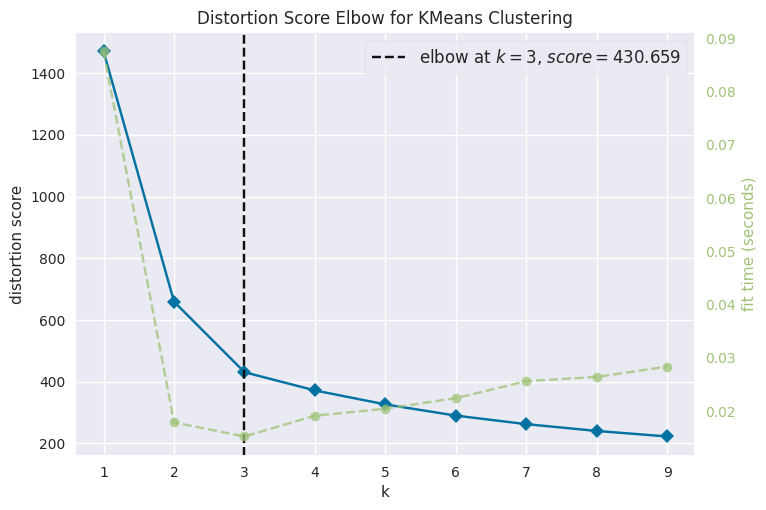

In [ ]:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X)
visualizer.show()
plt.show()

Как можно заметить, по правилу локтя оптимальное число кластеров получилось равным 3; это первое свидетельство об адекватности применения K-means.

Теперь обучим сам алгоритм и выведем численности получившихся кластеров

In [ ]:
algo = KMeans(n_clusters = 3, **kmeans_params)
algo.fit(X)
centroids = algo.cluster_centers_

y_kmeans = algo.fit_predict(X)
data['cluster_kmeans'] = y_kmeans
data.groupby('cluster_kmeans').size()

cluster_kmeans
0    67
1    72
2    71
dtype: int64

Видим, что распределение по кластерам достаточно близко к равномерному, что является вторым свидетельством в пользу адекватности K-means в данной задаче.

Для удобной работы переименуем кластеры сообразно меткам в исходном датасете

In [ ]:
y_kmeans_0 = y_kmeans == 0
y_kmeans_1 = y_kmeans == 1
y_kmeans_2 = y_kmeans == 2

y_kmeans[y_kmeans_0] = 2
y_kmeans[y_kmeans_1] = 3
y_kmeans[y_kmeans_2] = 1

data['cluster_kmeans'] = y_kmeans

Наконец, посчитаем accuracy на полученной разметке записей через кластеры

In [ ]:
accuracy_score(data['category'], data['cluster_kmeans'])

0.919047619047619

Accuracy получилась достаточно хорошей, а это уже третье свидетельство в пользу K-means.


По итогу можно сказать, что самый простой метод кластеризации достаточно хорошо применим в данной задаче. Поэтому можно переходить к отрисовке полученных кластеров

# Понижение размерности и отображение кластеров в 2D

## PCA

Для начала попробуем понизить размерность с помощью метода главных компонент

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# преобразуем в датафрейм
principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
principal_df['cluster'] = y_kmeans
principal_df['real_label'] = data.category

principal_df.head()

,PC1,PC2,cluster,real_label
0,0.317047,0.783669,1,1.0
1,-0.003386,1.913214,1,1.0
2,-0.459443,1.907225,1,1.0
3,-0.591936,1.931069,1,1.0
4,1.102910,2.068090,1,1.0


In [ ]:
pca.explained_variance_ratio_.sum()

0.8898248618491238

Видим, что выбранные два признака практически на 90% объясняют вариацию исходных данных, что является очень хорошим показателем. Отобразим теперь все на плоскости

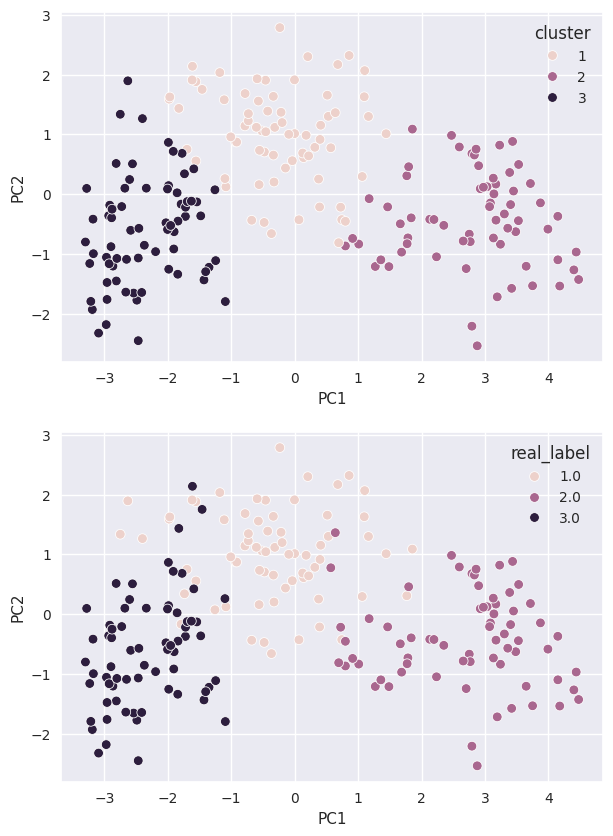

In [ ]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='cluster')

plt.subplot(2,1,2)
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='real_label')

plt.show()

По получившейся картинке можно сказать, что полученные признаки не очень способствуют отделению кластеров на картинке, ибо внутрикластерные расстояния получаются достаточно большими, из-за чего нельзя провести какую-то четкую разграничительную черту. Попробуем сравнить с результатами работы других методов

## T-SNE

Попробуем снизить размерность с помощью стохастического метода t-SNE

In [ ]:
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# преобразуем в датафрейм
tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne1', 'tsne2'])
tsne_df['cluster'] = y_kmeans
tsne_df['real_label'] = data.category

tsne_df.head()

,tsne1,tsne2,cluster,real_label
0,2.449142,0.753903,1,1.0
1,3.063771,-1.189869,1,1.0
2,1.144440,-5.075435,1,1.0
3,0.720256,-4.684542,1,1.0
4,5.040969,-1.299300,1,1.0


Отобразим все на плоскости

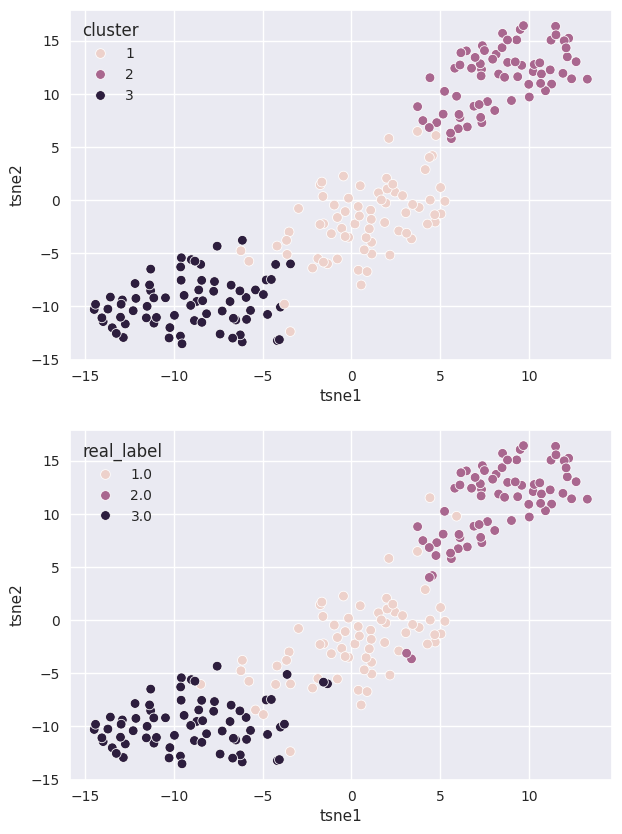

In [ ]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster')

plt.subplot(2,1,2)
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='real_label')

plt.show()

В данном случае кластеры выражаются ярче; во многом это связано с некой "линейностью" получающейся структуры, в результате чего кластеры более компактно располагаются на пласкости. В целом, полученные признаки (как результат работы метода t-sne) кажутся более применимыми, нежели в пердыдущем случае

## UMAP

Напоследок, попробуем понизить размерность с помощью метода UMAP

In [ ]:
# UMAP
um = umap.UMAP()
X_umap = um.fit_transform(X)

# преобразуем в датафрейм
umap_df = pd.DataFrame(data = X_umap, columns = ['umap1', 'umap2'])
umap_df['cluster'] = y_kmeans
umap_df['real_label'] = data.category

umap_df.head()

,umap1,umap2,cluster,real_label
0,4.893405,3.145571,1,1.0
1,4.523174,3.478784,1,1.0
2,2.732085,3.589604,1,1.0
3,2.811374,3.582042,1,1.0
4,4.617321,4.058959,1,1.0


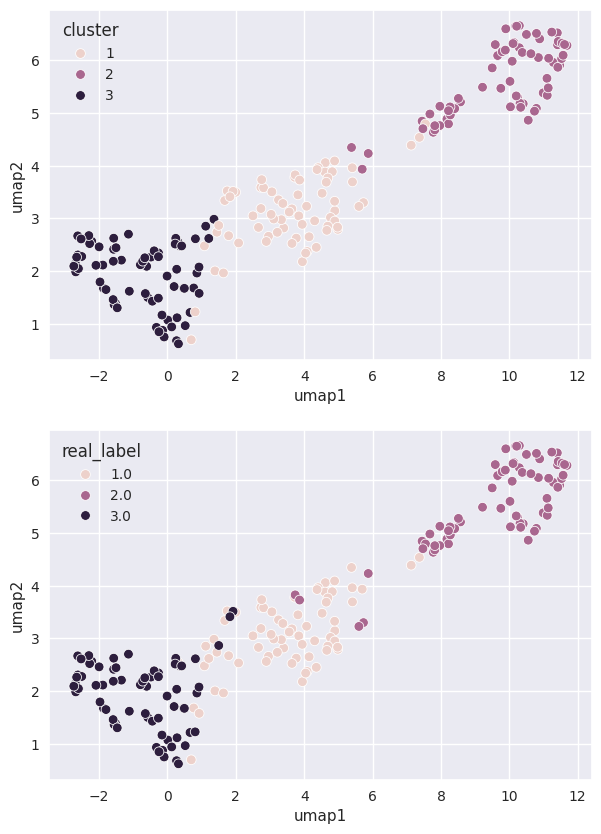

In [ ]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.scatterplot(data=umap_df, x='umap1', y='umap2', hue='cluster')

plt.subplot(2,1,2)
sns.scatterplot(data=umap_df, x='umap1', y='umap2', hue='real_label')

plt.show()

В данном случае мы вновь видим некоторую "линейную" структуру, однако несколько более разреженную, чем в t-SNE: между соседними кластерами начинают выделяться отдельные компоненты, которые не имеют адекватной интерпретации (а при незнании исходного количества групп могут и вовсе считаться за отдельные кластера). В целом, полученный результат кажется несколько хуже, чем результат работы t-SNE